In [1]:
from functools import partial
import jax
from jax import grad, jit, lax, random, vmap
import jax.numpy as jnp
import jax.scipy as scipy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

/Users/marlinfiggins/opt/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/Users/marlinfiggins/opt/anaconda3/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [3]:
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["font.size"] = 24

# Bayesian Methods

In [4]:
SEED = 4 * 13 * 2022
key = random.PRNGKey(SEED)
key, subkey = random.split(key)

## Joint probability distributions

The main idea behind these Bayesian methods is that we consider a distribution of possible parameters $\theta$ alongside our data $y$. This means that when building a model, we are attempting to discribe a joint probability distribution between our data and our parameters:

$$
(y, \theta) \mapsto p(y, \theta).
$$

In this way, fixing parameters $\theta_{0}$ and simulating data means conditioning this joint distribution on fixed $\theta_{0}$, so that we have $p(y \mid \theta = \theta_{0})$. Having data means that we're instead conditioning on fixed $y_{\text{obs}}$, so that we have $p(\theta \mid y = y_{\text{obs}})$. In short, actually finding this distribution means we gave a distribution of parameters which are consistent with the data we've observed. This is called the **posterior distribution**. 

## Encoding prior information

In order to get these estimates, we need to first specify a probability model on our parameters $\theta$. This is more of an art than a science. Typically, you can use diffusive priors (with a high variance) when you're largely uncertain of parameter values and tighter priors when you have more confidence. Additionally, we can use prior distributions that constrain the possible values of our parameters to intervals of interest. For example, this might include restricting the probability of winning a coin flip to $[0,1]$.

In general, we will want to simulate from the prior distirbution to see if we can replicate behavior similar to our model and to see if we're reasonably distributing our prior probability mass.

## Getting a posterior distribution

Given that we've observed our data, what is the most likely distribution of underlying parameters. In short, we get a posterior distribution by conditioning on our observed data, so that

\begin{align}
p(\theta \mid y) &= \frac{p(y, \theta)}{p(y)}\\
                 &= \frac{p(y\mid \theta) p(\theta)}{p(y)}\\
                 &= \frac{ L(\theta \mid y) p(\theta)}{\int_{\Theta} p(y\mid \theta) d\theta}
\end{align}

In the above, we've been able to split our posterior distribution into a term that is the likelihood from the previous notebook, the prior, and a scaling factor which does not depend on $\theta$ (it's an integral over all possible $\theta$).

## Obtaining the posterior

There are various methods for obtaining the posterior. Sometimes, we can take advantages of conjugacies between certain distributions to get the posterior in analytic or somewhat simplified form. We can also use methods for drawing samples from our posterior distribution called Markov Chain Monte Carlo (MCMC). There are also other methods from drawing from complicated distributions, but the gold standard is really MCMC. Other (collections of) methods such as variational Bayes are becoming popular nowadays as folks try to scale this framework to bigger data sets.

In general, Bayesian methods are very good for complicated models where uncertainty quantification is desired or one would like incorporate uncertainty in parameter values into the model fitting process.

## Example: Linear regression returns

Let's cast the same linear regression problem into a Bayesian context.


\begin{align}
\beta \sim_{\text{i.i.d}} \text{Normal}(0, 100)\\
\sigma \sim \text{HalfNormal}(0, 20)\\
y \sim \text{Normal}(X \beta, \sigma)
\end{align}


In [5]:
## Linear models
def linear_expectation(X, β):
    return jnp.dot(X, β)

def simulate_linear_data(X, β, σ, key = None):
    if key is None:
        key = random.PRNGKey(SEED)
        
    key, subkey = random.split(key)
    EY = jnp.dot(X, β)
    return EY + σ*random.normal(subkey, EY.shape)

X = jnp.stack([jnp.repeat(1, 100), 
               jnp.array([t for t in range(100)])]).T # Feature matrix
β = jnp.array([2.0, 0.1]) # True parameters
σ = 1.0 # Noise level

Y = simulate_linear_data(X, β, σ, key = key) # Simulated data

Text(0, 0.5, 'Brownies consumed')

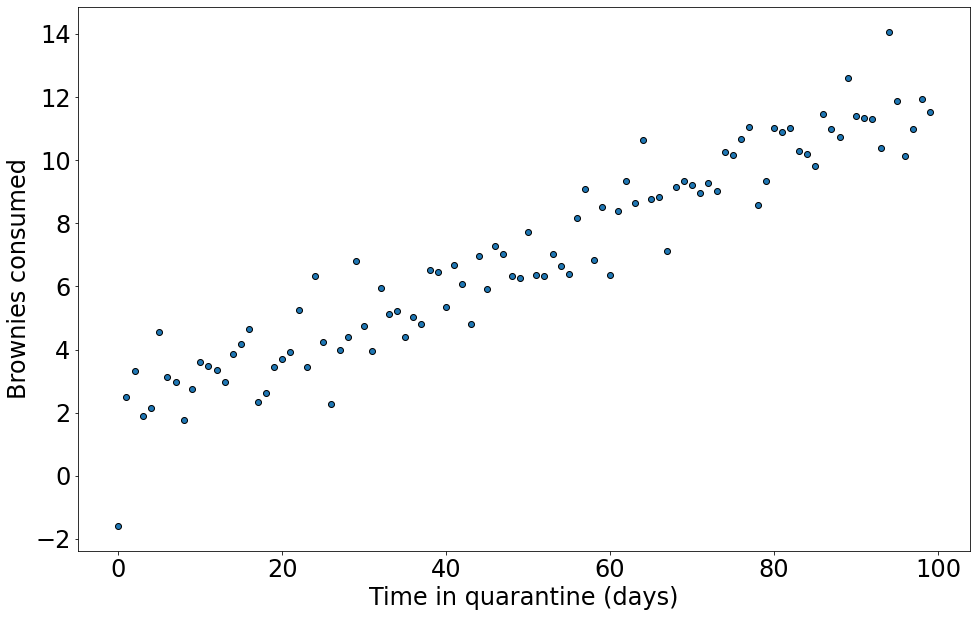

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 
ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

In [7]:
def linear_regression(X, Y = None):
    β_shape = X.shape[1]
    
    with numpyro.plate("i", β_shape):
        beta = numpyro.sample("beta", dist.Normal(0, 100))
    
    sigma = numpyro.sample("sigma", dist.TruncatedNormal(
        low=0.0,
        loc=0.0,
        scale= 100.0,
        ))
    
    EY = numpyro.deterministic("EY", jnp.dot(X, beta))
    numpyro.sample("Y", dist.Normal(EY, sigma), obs=Y)
    return None

In [8]:
# use dense_mass for better mixing rate
MCMC_PARMS = {"num_warmup": 500, "num_samples": 500, "num_chains": 1}

mcmc = MCMC(NUTS(linear_regression, dense_mass=True),
            num_warmup=MCMC_PARMS["num_warmup"],
            num_samples=MCMC_PARMS["num_samples"],
            num_chains=MCMC_PARMS["num_chains"])

key, subkey = random.split(key)
mcmc.run(key, X=X, Y=Y)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 396.14it/s, 3 steps of size 3.32e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      1.84      0.19      1.84      1.55      2.18    296.01      1.00
   beta[1]      0.10      0.00      0.10      0.10      0.11    330.43      1.00
     sigma      0.99      0.07      0.98      0.88      1.10    318.19      1.00

Number of divergences: 0


In [9]:
samples = mcmc.get_samples() # Retrieve posterior samples

In [10]:
samples

{'EY': DeviceArray([[ 1.5041559,  1.6149781,  1.7258002, ..., 12.253903 ,
               12.364726 , 12.475548 ],
              [ 1.9567462,  2.0612345,  2.1657226, ..., 12.092102 ,
               12.19659  , 12.301079 ],
              [ 1.9985075,  2.0984335,  2.1983595, ..., 11.691327 ,
               11.791253 , 11.891179 ],
              ...,
              [ 1.8911588,  1.99461  ,  2.098061 , ..., 11.925923 ,
               12.029375 , 12.132826 ],
              [ 1.9325675,  2.0322547,  2.1319418, ..., 11.602223 ,
               11.701911 , 11.801598 ],
              [ 1.862228 ,  1.9661402,  2.0700521, ..., 11.9417   ,
               12.045611 , 12.149524 ]], dtype=float32),
 'beta': DeviceArray([[1.5041559 , 0.11082214],
              [1.9567462 , 0.10448821],
              [1.9985075 , 0.09992598],
              [1.7809819 , 0.1063614 ],
              [1.848085  , 0.1054038 ],
              [1.7591205 , 0.1031462 ],
              [1.5925714 , 0.10625421],
              [2.01267

(array([ 3.,  5.,  5.,  6., 17., 20., 35., 52., 53., 69., 66., 45., 38.,
        36., 20., 14.,  8.,  4.,  3.,  1.]),
 array([1.2698511, 1.3281229, 1.3863947, 1.4446665, 1.5029384, 1.5612102,
        1.619482 , 1.6777538, 1.7360257, 1.7942975, 1.8525693, 1.9108411,
        1.9691129, 2.0273848, 2.0856566, 2.1439283, 2.2022002, 2.260472 ,
        2.318744 , 2.3770156, 2.4352875], dtype=float32),
 <BarContainer object of 20 artists>)

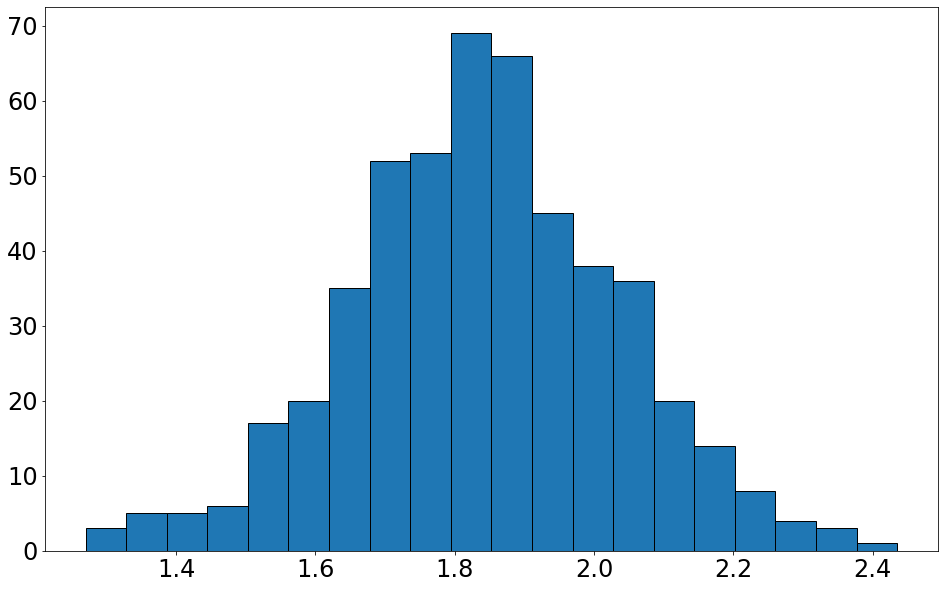

In [11]:
plt.hist(np.array(samples["beta"][:,0]), bins=20, ec="k")

(array([ 2.,  4.,  6., 13., 26., 32., 36., 46., 61., 58., 57., 55., 39.,
        29., 18.,  6.,  5.,  4.,  2.,  1.]),
 array([0.09430271, 0.0953232 , 0.09634368, 0.09736416, 0.09838466,
        0.09940514, 0.10042562, 0.10144611, 0.10246659, 0.10348707,
        0.10450757, 0.10552805, 0.10654853, 0.10756902, 0.1085895 ,
        0.10960998, 0.11063047, 0.11165096, 0.11267144, 0.11369193,
        0.11471241], dtype=float32),
 <BarContainer object of 20 artists>)

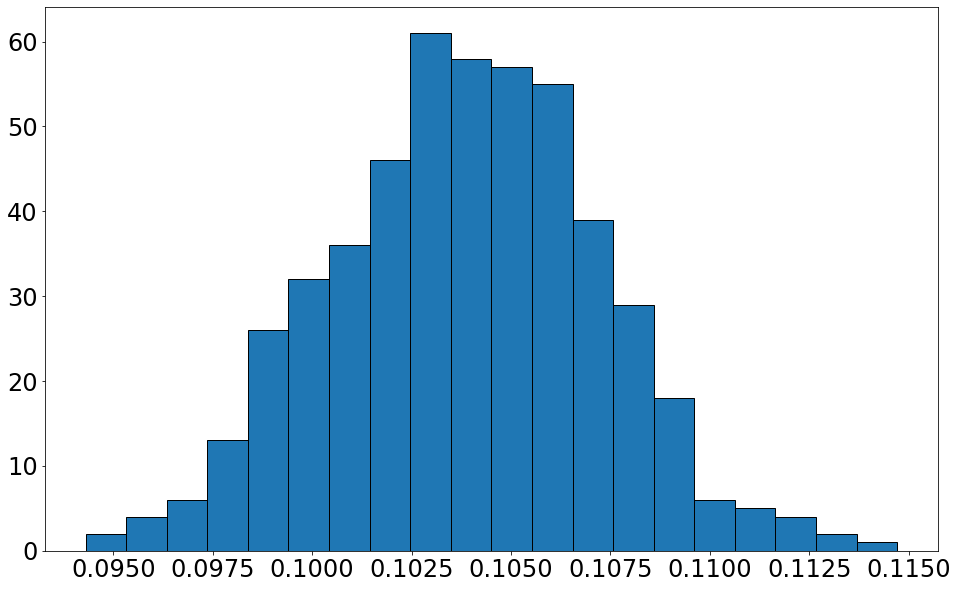

In [12]:
plt.hist(np.array(samples["beta"][:,1]), bins=20, ec="k")

Text(0, 0.5, 'Brownies consumed')

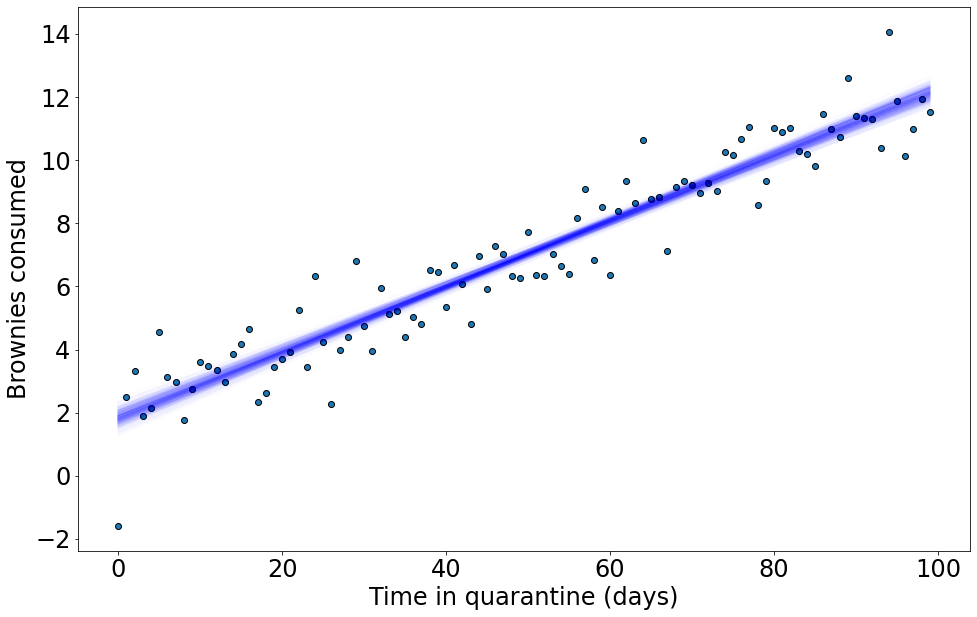

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 

ax.plot(X[:,1], samples["EY"].T, color = "b", alpha = 0.01)
ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

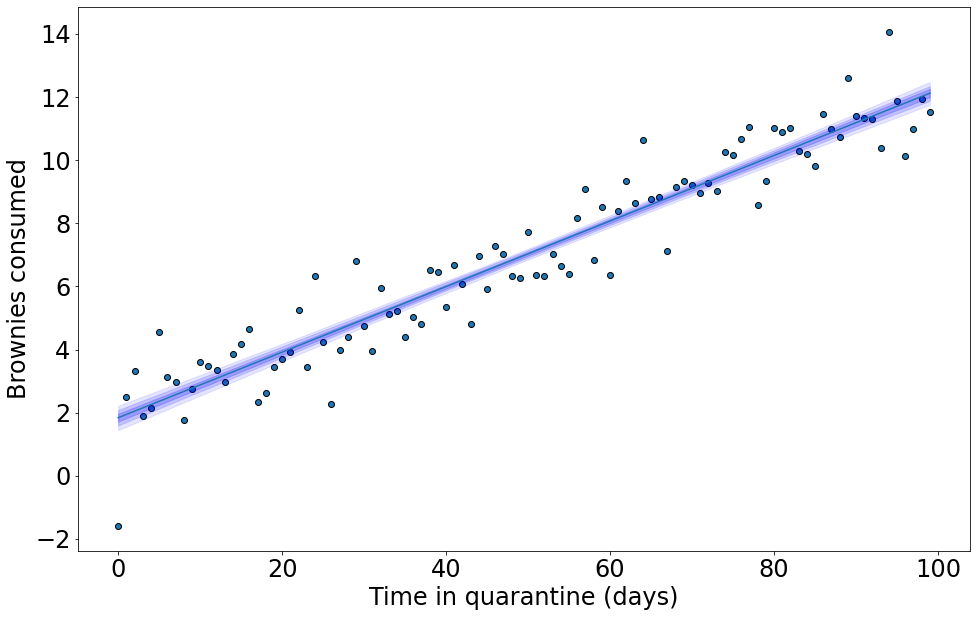

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 

# Plot 95%
mu, pi = jnp.mean(samples["EY"], 0), jnp.percentile(samples["EY"], jnp.array([2.5, 97.5]), 0)
ax.fill_between(X[:,1], pi[0,:],  pi[1,:], color="b",  alpha=0.1)

# Plot 80%
mu, pi = jnp.mean(samples["EY"], 0), jnp.percentile(samples["EY"], jnp.array([10, 90]), 0)
ax.fill_between(X[:,1], pi[0,:],  pi[1,:], color="b",  alpha=0.15)

# Plot 50%
mu, pi = jnp.mean(samples["EY"], 0), jnp.percentile(samples["EY"], jnp.array([25, 75]), 0)
ax.fill_between(X[:,1], pi[0,:],  pi[1,:], color="b",  alpha=0.2)
ax.plot(X[:,1], mu)

ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

fig;

## Example: Fitting the Lotka-Volterra model 

We'll now fit a Bayesian version of our Lotka-Volterra model. The idea and model here are borrowed from
[Example: Predator-Prey Model — NumPyro  documentation](https://num.pyro.ai/en/stable/examples/ode.html) and [Predator-Prey Population Dynamics:  the Lotka-Volterra model in Stan](https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html) with slight changes.

In [15]:
from jax.experimental.ode import odeint

@jit
def LV_step(u, t, θ):
    x, y =  (u[0], u[1])
    α, β, γ, δ = (θ[0], θ[1], θ[2], θ[3])
    
    dx_dt = (α - β*y)*x
    dy_dt = (-γ + δ*x)*y
    return jnp.stack([dx_dt, dy_dt])

true_θ = (0.55, 0.028, 0.8, 0.024)    
σ = 0.1 
u0 = jnp.array([30., 4.])
t = jnp.arange(20.)
Y = odeint(LV_step, u0, t, true_θ)

In [17]:


# Borrowed from: https://num.pyro.ai/en/stable/examples/ode.html
def model(N, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    
    # measurement times
    ts = jnp.arange(float(N))
    # parameters alpha, beta, gamma, delta of dz_dt
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 0.05, 1.0, 0.05]),
            scale=jnp.array([0.5, 0.05, 0.5, 0.05]),
        ),
    )
    
    # Integrate Lotka-Volterra equations
    z = odeint(LV_step, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    
    # measurement errors
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([2]))
    # measured populations
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)
    return None
   
# Simualate synthetic data
data = dist.LogNormal(jnp.log(Y), σ).sample(key)

In [18]:
# use dense_mass for better mixing rate
MCMC_PARMS = {"num_warmup": 500, "num_samples": 500, "num_chains": 1}

mcmc = MCMC(NUTS(model, dense_mass=True),
            num_warmup=MCMC_PARMS["num_warmup"],
            num_samples=MCMC_PARMS["num_samples"],
            num_chains=MCMC_PARMS["num_chains"])

key, subkey = random.split(key)
mcmc.run(key, N=data.shape[0], y=data)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:05<00:00, 169.04it/s, 7 steps of size 5.40e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.12      0.02      0.12      0.09      0.15    481.58      1.00
  sigma[1]      0.12      0.02      0.11      0.08      0.15    431.34      1.00
  theta[0]      0.53      0.02      0.53      0.49      0.57    487.25      1.00
  theta[1]      0.03      0.00      0.03      0.02      0.03    467.18      1.00
  theta[2]      0.84      0.04      0.84      0.79      0.90    640.29      1.00
  theta[3]      0.03      0.00      0.03      0.02      0.03    496.12      1.01
 z_init[0]     29.13      1.14     29.07     27.27     30.92    652.66      1.00
 z_init[1]      3.94      0.17      3.94      3.66      4.21    780.06      1.00

Number of divergences: 0


## Posterior predictive populations

Using the samples from the posterior generated by MCMC, we can predict new data which would be observed from these posterior populations. This probability distribution of new data is called the "posterior predictive distribution". If the model fit is good, then the posterior predictive distribution will be well-matched with the observed data.

In [19]:
# predict populations
pop_pred = Predictive(model, mcmc.get_samples())(subkey, data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), jnp.percentile(pop_pred, jnp.array([10, 90]), 0)
year = 1900 + t

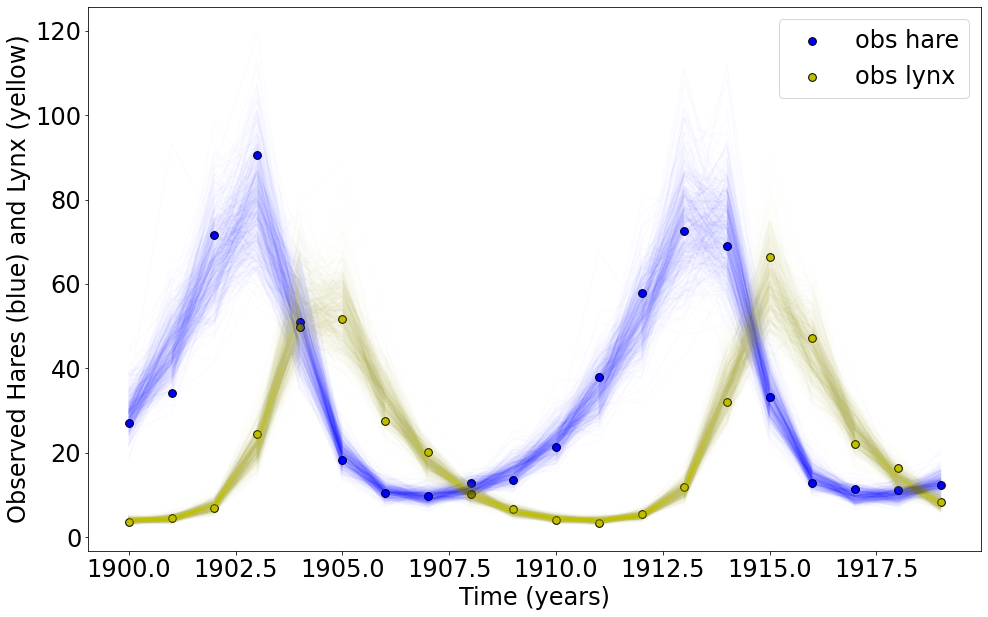

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(year, data[:, 0], color = "b", label="obs hare", s = 60, edgecolors='k')
ax.plot(year, pop_pred[:,:,0].T, color="b", alpha=0.01)

ax.scatter(year, data[:, 1], color = "y", label="obs lynx", s = 60, edgecolors='k')
ax.plot(year, pop_pred[:,:,1].T, color="y", alpha=0.01)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")
ax.legend()


## Investigating the posterior

Using our sampled parameters, we'll integrate the differential equations to get estimates of the true populations. We can use this approach to get probabalistic forecasts of the population.

In [21]:
samples = mcmc.get_samples() # Retrieve posterior samples

In [22]:
def run_LV(theta, z_init, ts):
    return odeint(LV_step, z_init, ts, theta, rtol=1e-6, atol=1e-5)

run_LV_batched = vmap(run_LV, in_axes = (0, 0, None)) # Batching integration over posterior samples
ts = jnp.arange(0, 30, 0.05) # Time span to integrate over
posterior_dynamics = run_LV_batched(samples["theta"], samples["z_init"], ts) # Get posterior dynamics

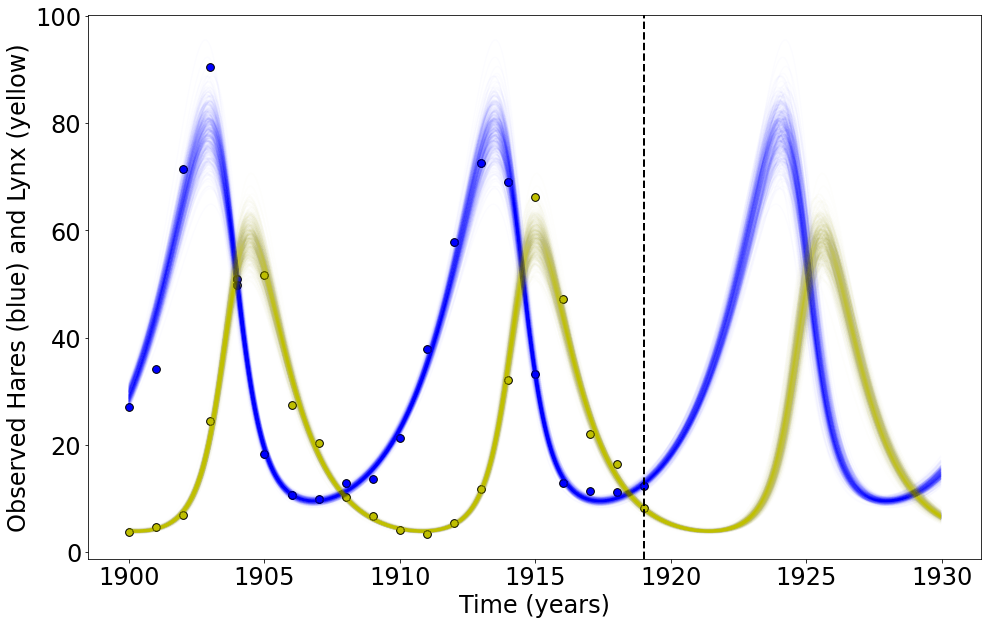

In [23]:
# Plot posterior dynamics
fig = plt.figure()
ax = fig.add_subplot(111)

plt_ts = 1900 + ts
ax.plot(plt_ts, posterior_dynamics[:,:,0].T, color="b", alpha=0.01, label="hare population")
ax.plot(plt_ts, posterior_dynamics[:,:,1].T, color="y", alpha=0.01, label="lynx population")

ax.scatter(year, data[:, 0], color = "b", label="obs hare", s = 60, edgecolors='k')
ax.scatter(year, data[:, 1], color = "y", label="obs lynx", s = 60, edgecolors='k')

ax.axvline(year[-1], linewidth=2, color='k', linestyle = "--")

ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")
fig;

In [24]:
# Get uncertainty intervals from samples
mu, pi = jnp.mean(posterior_dynamics, 0), jnp.percentile(posterior_dynamics, jnp.array([10, 90]), 0)

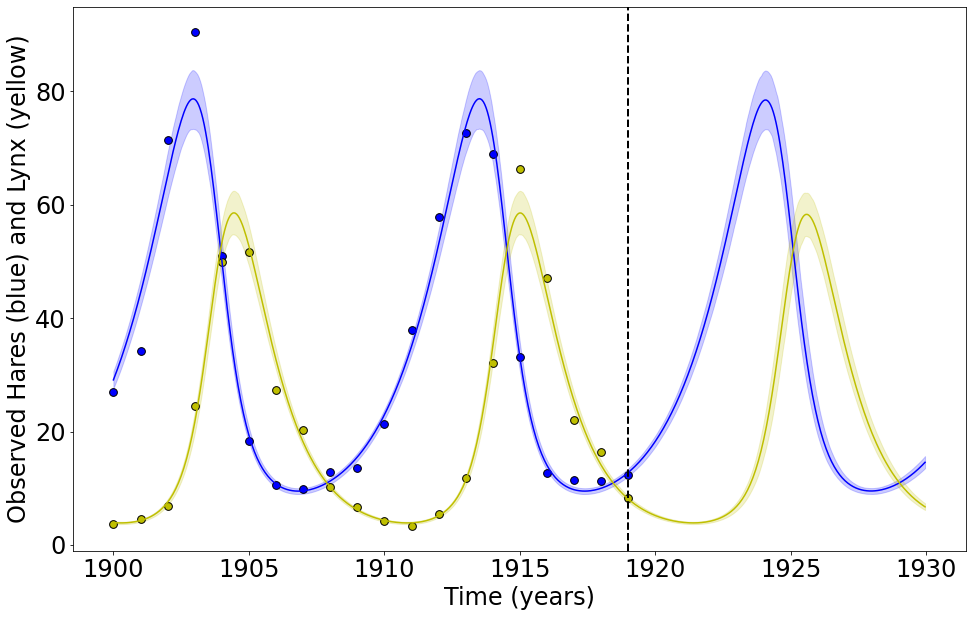

In [25]:
# Plot posterior dynamics with uncertainty
fig = plt.figure()
ax = fig.add_subplot(111)

plt_ts = 1900 + ts
ax.plot(plt_ts, mu[:,0], color="b", label="hare population")
ax.fill_between(plt_ts, pi[0,:,0],  pi[1,:,0], color="b", alpha=0.2)

ax.plot(plt_ts, mu[:,1], color="y", label="lynx population")
ax.fill_between(plt_ts, pi[0,:,1],  pi[1,:,1], color="y",  alpha=0.2)

ax.scatter(year, data[:, 0], color = "b", label="obs hare", s = 60,edgecolors='k')
ax.scatter(year, data[:, 1], color = "y", label="obs lynx", s = 60, edgecolors='k')

ax.axvline(year[-1], linewidth=2, color='k', linestyle = "--")

ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")
fig;

## Example: Fitting Time Varying SIR

This is a more involved example using an SIR model with time-varying $\beta(t)$ and waning immunity to explain reccurrent epidemics.

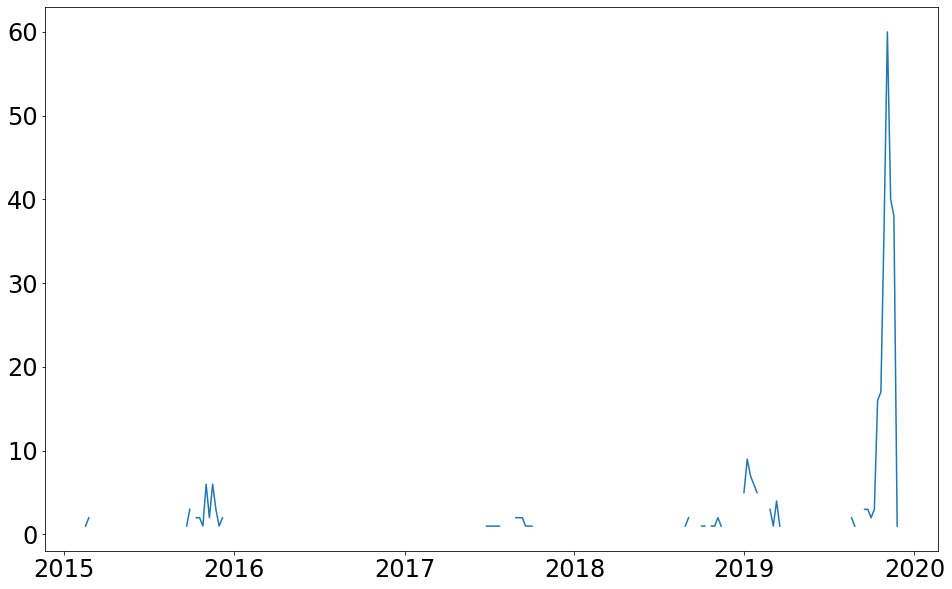

In [121]:
import pandas as pd
raw_df = pd.read_csv("../data/Flu_Caribbean.csv")
raw_df["SDATE"]=pd.to_datetime(raw_df["SDATE"])
raw_df["EDATE"]=pd.to_datetime(raw_df["EDATE"])
raw_df = raw_df[raw_df.Country == "Trinidad and Tobago"]

# Plottig real Influenza data from Trinidad and Tobago
plt.plot(raw_df.SDATE, raw_df.ALL_INF)

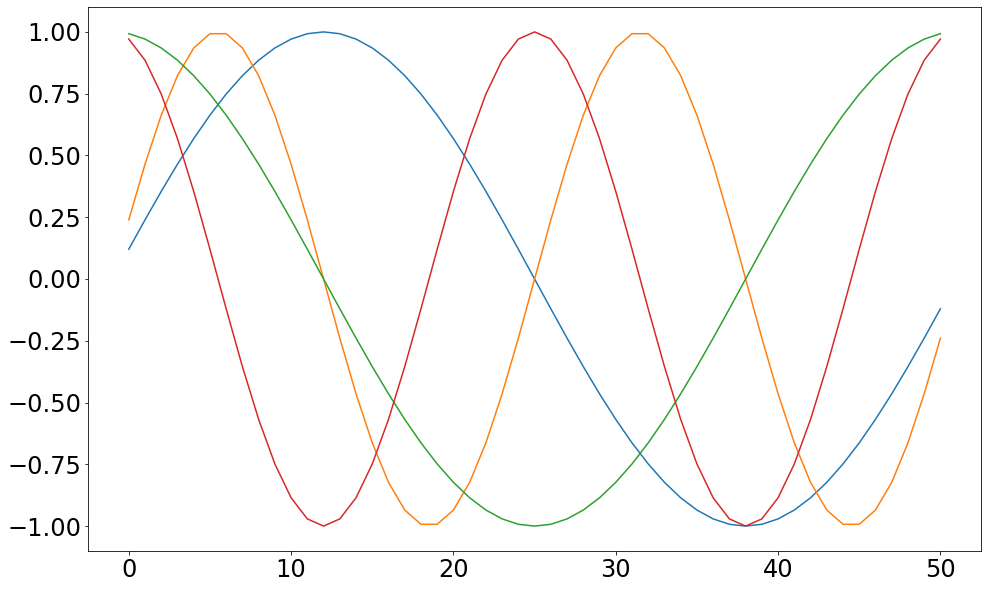

In [28]:
from jax.experimental.ode import odeint

# Do simple Fourier fit for this?
# Learn coefficients for the spline with negative binomial
# We have weekly data, so parameters will be in terms of per week.\

P = 52 # Fifty two week period
k = 2 # Degree of sin and cos

# Construct fourier basis
@jit
def fourier_basis(t):
    "Return Fourier basis at time t"
    arg = 2*jnp.pi/P*jnp.arange(1, k+1) 
    return jnp.hstack([jnp.sin(arg*t), jnp.cos(arg*t)])

# Plotting fourier basis over a period
plt.plot(vmap(fourier_basis)(jnp.arange(1, P)))

In [29]:
N = 10_000

@jit
def SIRS_step(u, t, p):
    S, I, R, CI = (u[0], u[1], u[2], u[3])
    gam, omega, theta  = p[0], p[1], p[2:]
    
    # Compute beta from Fourier series
    beta = jnp.exp(jnp.dot(fourier_basis(t), theta))
    
    lam = beta * S * I / N
    recov = gam*I
    wane = omega * R
    
    dS = -lam + wane
    dI = lam - recov
    dR = recov - wane
    dCI = lam
    return jnp.stack([dS, dI, dR, dCI])


# Simulating toy data set with the Fourier model
true_θ = jnp.array([1/10 * 7, 1/30 * 7, 0.21, 0.1, 0.21, -0.2])    
u0 = jnp.array([N, 1, 0.0, 0.0]) # Initial condition
t = jnp.arange(200.) # Simulate for 200 weeks
Y = odeint(SIRS_step, u0, t, true_θ) # Integrate 

Text(0, 0.5, '$R_{t}$')

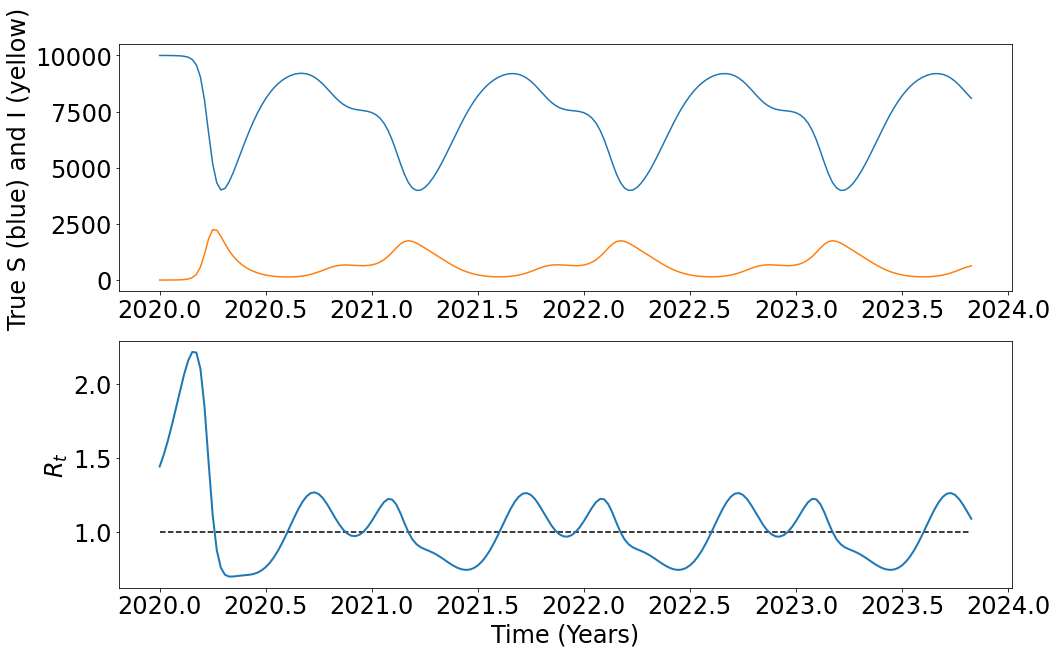

In [30]:
fig = plt.figure()
ax = fig.add_subplot(211)

plt_t = 2020 + t / 52
ax.plot(plt_t, Y[:,0:2], label="hare population")

ax.set_xlabel("")
ax.set_ylabel("True S (blue) and I (yellow)")
fig;

# Plotting effective reproduction number
ax_2 = fig.add_subplot(212, sharex=ax)

beta = jnp.exp(
    jnp.dot(vmap(fourier_basis)(t), jnp.array(true_θ[2:])) # Multiply Fourier basis by coefficients
)

R_t = beta  * Y[:, 0] / (true_θ[0] * N)
ax_2.hlines(xmin=plt_t[0], xmax=plt_t[-1], y=1., color="k", linestyle="--")
ax_2.plot(plt_t, R_t, linewidth=2.0)

ax_2.set_xlabel("Time (Years)")
ax_2.set_ylabel(r"$R_{t}$")

In [31]:
# Simulate incidence
True_Inc = jnp.diff(Y[:,-1], prepend=0.) # Return weekly incidence
key, subkey = random.split(key)
data = jax.random.poisson(key=subkey, lam=True_Inc, shape=True_Inc.shape)

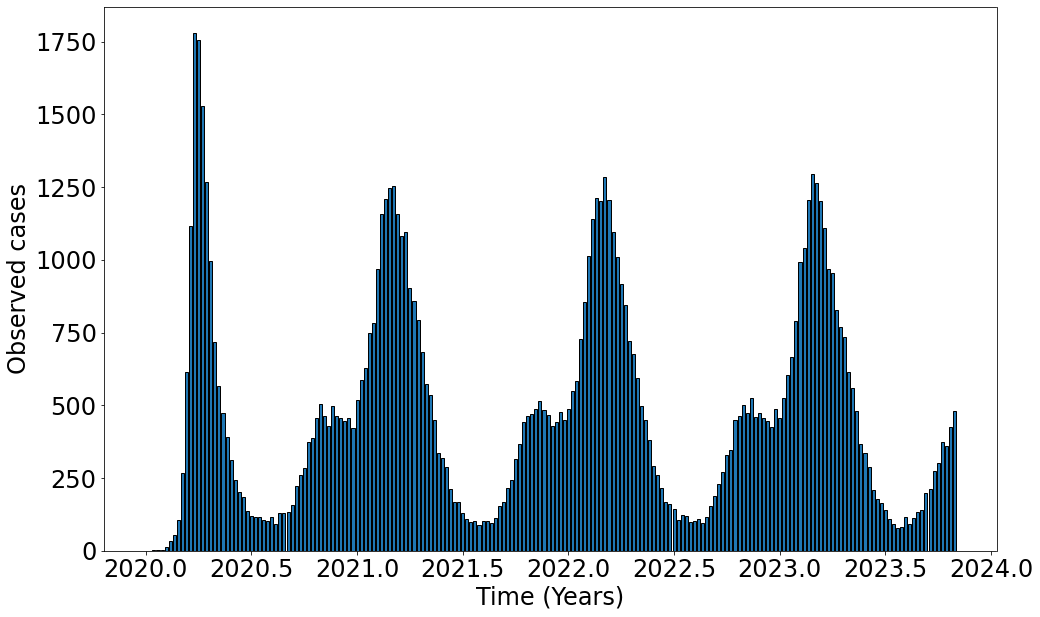

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt_t = 2020 + t / 52
ax.bar(plt_t, data, width=0.75/52, label="hare population", ec="k")
ax.set_xlabel("Time (Years)")
ax.set_ylabel("Observed cases")
fig;

In [49]:
def SIR_model(t, y=None):
    """
    :param int t: measurement times
    :param numpy.ndarray y: observed population sizes
    """
    
    # measurement times
    # parameters gamma, omega, theta
    gam = numpyro.sample("gam", dist.Exponential(rate=10/7))
    omega = numpyro.sample("omega", dist.Exponential(rate=30/7))
    theta = numpyro.sample("theta", dist.Normal().expand([4]))
    
    p = jnp.hstack((gam, omega, theta))

    # Integrate Lotka-Volterra equations
    Y = odeint(SIRS_step, jnp.hstack([N, 1., 0., 0.]), 
               t,  p, 
               rtol=1e-6, atol=1e-5, mxstep=1000)

    # measured populations
    Inc = jnp.diff(Y[:,-1], prepend=1e-12) # Return weekly incidence
    numpyro.sample("y", dist.Poisson(jnp.clip(Inc, a_min=1e-12)), obs=y)
    return None

In [48]:
# use dense_mass for better mixing rate
MCMC_PARMS = {"num_warmup": 500, "num_samples": 200, "num_chains": 1}

mcmc = MCMC(NUTS(SIR_model, dense_mass=True),
            num_warmup=MCMC_PARMS["num_warmup"],
            num_samples=MCMC_PARMS["num_samples"],
            num_chains=MCMC_PARMS["num_chains"])

key, subkey = random.split(key)
mcmc.run(key, t=t, y=data)
mcmc.print_summary()

  0%|          | 0/700 [00:00<?, ?it/s]

[-9.99999996e-13  5.82797461e+03  4.84794727e+03  1.22635254e+03
  1.11664355e+03  8.31354492e+02  4.97340820e+02  2.30865234e+02
  8.35498047e+01  2.48183594e+01  6.52636719e+00  1.63574219e+00
  4.15039062e-01  1.11328125e-01  2.92968750e-02  9.76562500e-03
  7.81250000e-03  1.95312500e-03  1.26953125e-02 -1.26953125e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.88281250e-03
  5.76171875e-02  1.11425781e+00  2.40820312e+01  3.92036133e+02
  2.65934961e+03  3.81699609e+03  1.89342773e+03  9.31816406e+02
  5.24945312e+02  3.04107422e+02  1.76882812e+02  1.05240234e+02
  6.63300781e+01  4.61914062e+01  3.74667969e+01  3.78222656e+01
  5.22675781e+01  1.13751953e+02  4.67330078e+02  3.16901562e+03
  5.66439844e+03  2.03538672e+03  1.77327344e+03  1.97328906e+03
  2.02203906e+03  1.93433984e+03  1.79411328e+03  1.59230078e+03
  1.30135938e+03  9.28097656e+02  5.43195312e+02  2.49457031e+02
  8.98554688e+01  2.66289

Traced<ShapedArray(float32[200])>with<JVPTrace(level=4/1)> with
  primal = Traced<ShapedArray(float32[200])>with<DynamicJaxprTrace(level=2/1)>
  tangent = Traced<ShapedArray(float32[200])>with<JaxprTrace(level=3/1)> with
    pval = (ShapedArray(float32[200]), Traced<AbstractUnit()>with<DynamicJaxprTrace(level=2/1)>)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f90fce35ec0>, invars=(Traced<ShapedArray(float32[1]):JaxprTrace(level=3/1)>, Traced<ShapedArray(int32[1]):JaxprTrace(level=3/1)>, Traced<ShapedArray(int32[1]):JaxprTrace(level=3/1)>, Traced<ShapedArray(float32[200]):JaxprTrace(level=3/1)>), outvars=[<weakref at 0x7f90fb988900; to 'JaxprTracer' at 0x7f90fb988450>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(diff)', 'donated_invars': (False, False, False, False), 'inline': False, 'call_jaxpr': { lambda ; a:f32[1] b:i32[1] c:i32[1] d:f32[200]. let
    e:f32[201] = concatenate[dimension=0] a d
    f:f32[200] = gather[
      dimension_numbers=

sample: 100%|██████████| 700/700 [00:15<00:00, 46.27it/s, 7 steps of size 1.42e-01. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       gam      0.70      0.00      0.70      0.70      0.70     54.89      1.01
     omega      0.23      0.00      0.23      0.23      0.24     49.87      1.02
  theta[0]      0.21      0.00      0.21      0.20      0.21    110.63      1.01
  theta[1]      0.10      0.00      0.10      0.10      0.10     95.22      1.01
  theta[2]      0.21      0.00      0.21      0.21      0.21    113.15      1.00
  theta[3]     -0.20      0.00     -0.20     -0.20     -0.20    142.55      1.01

Number of divergences: 0


In [77]:
# predict populations
pop_pred = Predictive(SIR_model, mcmc.get_samples())(subkey, t)["y"]
mu, pi = jnp.mean(pop_pred, 0), jnp.percentile(pop_pred, jnp.array([10, 90]), 0)
year = 2020 + t/52

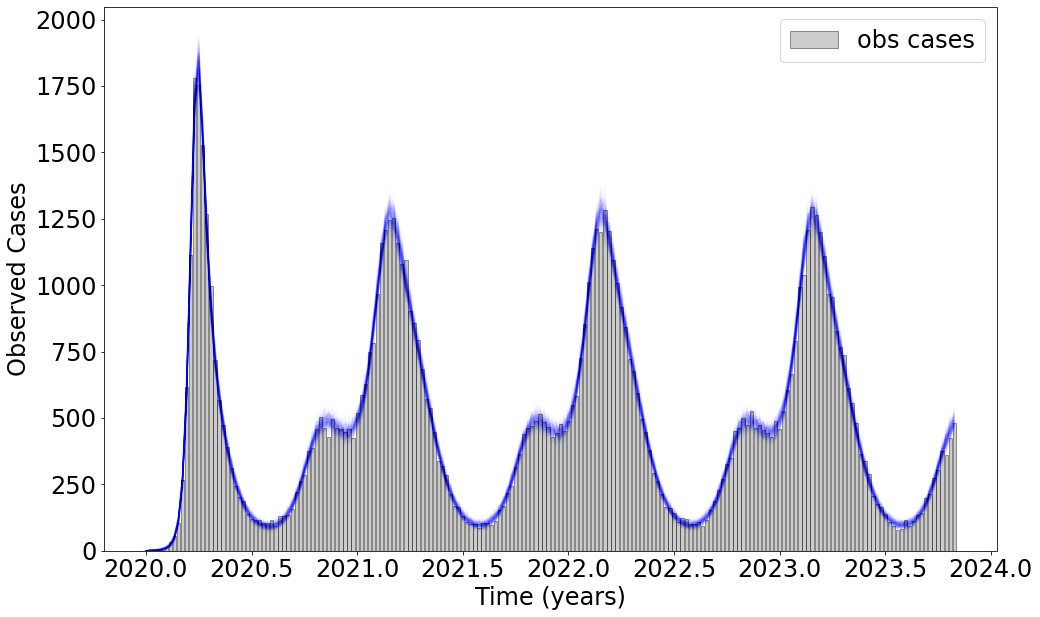

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar(year, data, color = "gray", alpha=0.4, label="obs cases", ec='k', width=0.8/52)
ax.plot(year, pop_pred.T, color="b", alpha=0.01)

ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Cases")
ax.legend()

In [105]:
samples = mcmc.get_samples()
gams = samples["gam"]
omegas = samples["omega"]
thetas = samples["theta"]
pred_t = jnp.arange(1,250.)


def run_SIRS(gam, omega, theta, ts):
    return odeint(SIRS_step, jnp.hstack([N, 1., 0., 0.]), ts, jnp.hstack((gam, omega, theta)), rtol=1e-6, atol=1e-5)

run_SIRS_batched = vmap(run_SIRS, in_axes = (0, 0, 0, None)) # Batching integration over posterior samples
posterior_dynamics = run_SIRS_batched(gams, omegas, thetas, pred_t) # Get posterior dynamics



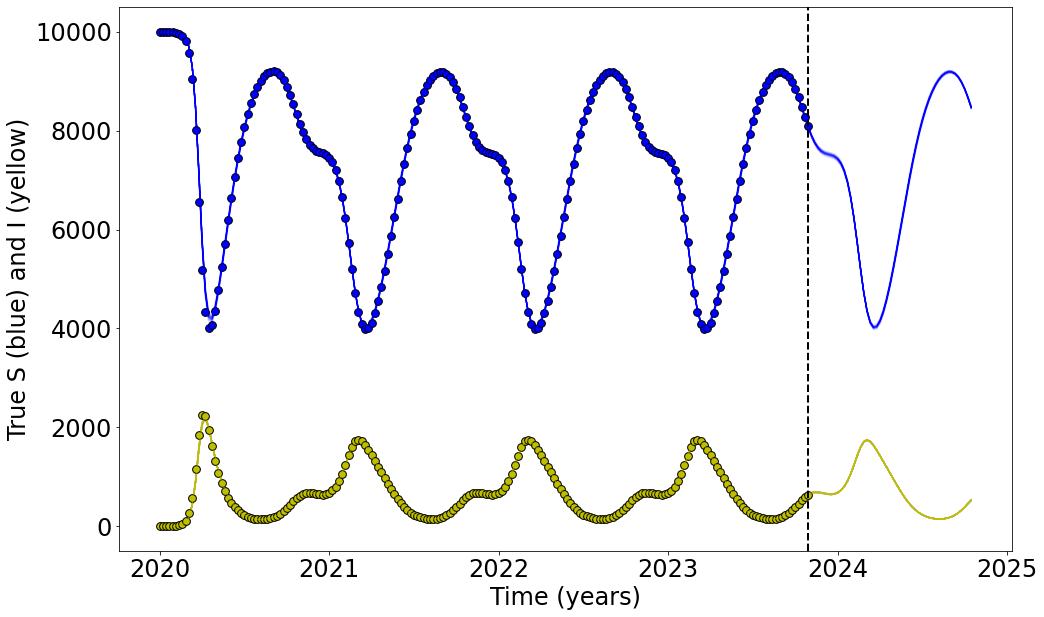

In [113]:
# Plot posterior dynamics
fig = plt.figure()
ax = fig.add_subplot(111)

year = 2020 + t/52
pred_year = 2020 + pred_t/52
ax.plot(pred_year, posterior_dynamics[:,:,0].T, color="b", alpha=0.01, label="hare population")
ax.plot(pred_year, posterior_dynamics[:,:,1].T, color="y", alpha=0.01, label="lynx population")

ax.scatter(year, Y[:, 0], color = "b", label="obs hare", s = 60, edgecolors='k')
ax.scatter(year, Y[:, 1], color = "y", label="obs lynx", s = 60, edgecolors='k')

ax.axvline(year[-1], linewidth=2, color='k', linestyle = "--")

ax.set_xlabel("Time (years)")
ax.set_ylabel("True S (blue) and I (yellow)")
fig;